# simple ocean model
Using the WeatherBench geopotential 500hPa model as an example to set up a first ocean model  
Most parts are just copied from the ECMWFs MOOC WeatherBench exampel

In [1]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import tensorflow as tf

#### import data

In [3]:
# path to shared folder - containing relevant data
root_era5 = '/content/drive/MyDrive/2024METFUT_project_data/ERA5/'

In [ ]:
# import the sea surface temperature fields
sst    = xr.open_mfdataset(root_era5+'sst_5.625deg/*.nc', combine='by_coords')
siconc = xr.open_mfdataset(root_era5+'siconc_5.625deg/*.nc', combine='by_coords')

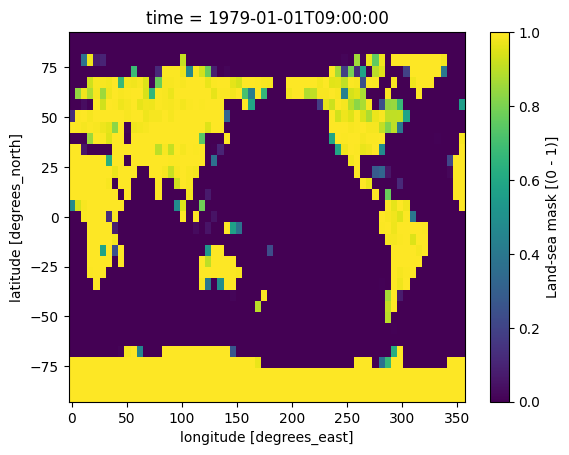

In [94]:
# import land sea mask and plot
lsm = xr.open_dataset(root_era5+'lsm_5.625deg.nc')
lsm.lsm.isel(time=0).plot()

In [5]:
# load data into memory
sst.load()
siconc.load()

<xarray.Dataset>
Dimensions:    (longitude: 64, latitude: 33, time: 16071)
Coordinates:
  * longitude  (longitude) float32 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * latitude   (latitude) float32 90.0 84.38 78.75 73.12 ... -78.75 -84.38 -90.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2022-12-31T09:00:00
Data variables:
    siconc     (time, latitude, longitude) float32 0.9818 0.9818 ... 0.0 0.0

The sea surface temperature data contains nan values, these need to be removed, otherwise the training of a neural network won't work  
-> For future projects include routine that checks for nan values

In [58]:
# check if dataset includes nans
np.isnan(sst.sst.values)
# fill nan values with daily climatology
sst_clim = sst.groupby('time.dayofyear').mean()
sst = sst.fillna(sst_clim.sel(dayofyear=sst.time.dt.dayofyear))

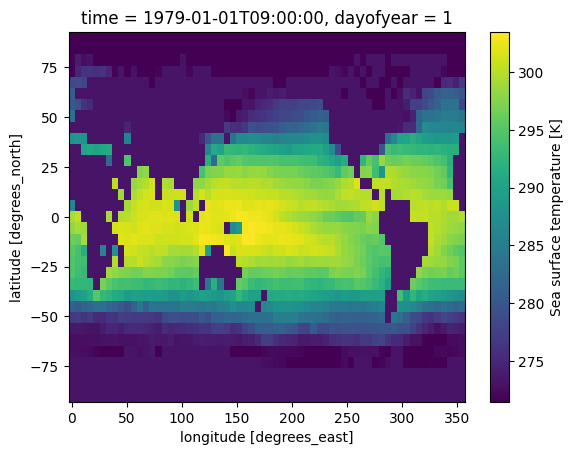

In [62]:
# plot the sea surface temperature at the first time step
sst.sst.isel(time=0).plot()

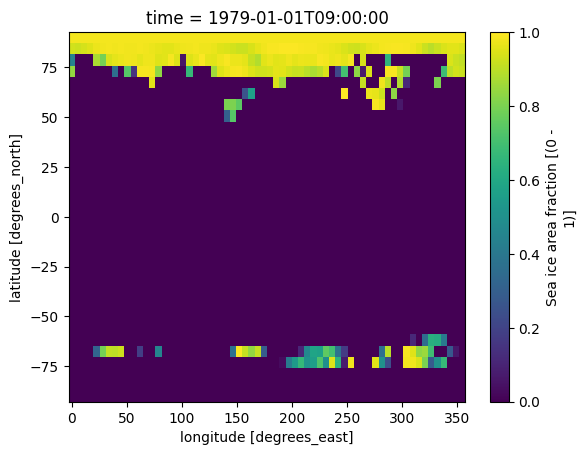

In [7]:
# plot the sea ice concentration at the first time step
siconc.siconc.isel(time=0).plot()

#### compare land sea mask to fill value of sst


## Build model for sea surface temperature

#### compute baselines

In [8]:
# training dataset selection
train_years = slice('1979', '1993')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('1993', '1995')
# test dataset selection
test_years = slice('1995', '1997')

In [9]:
def computed_weighted_rmse(fc, gt):
  """
  Error metric to compute the area averaged RMSE.
  Input forecast and ground truth
  """
  # calculations are only performed for points in space/time in both data sets
  # the rest is cut
  error = fc - gt
  weights_lat = np.cos(np.deg2rad(error.latitude))
  weights_lat /= weights_lat.mean()
  rmse = np.sqrt(((error)**2 * weights_lat).mean(('time', 'latitude', 'longitude')))
  return rmse

In [10]:
# pick the forecast lead time
lead_time_steps = 5 # 5 day forecast considering one time step
# compute persistent forecast
persistence_fc = sst.sel(time=test_years).isel(time=slice(0, -lead_time_steps))
persistence_fc['time'] = persistence_fc.time + np.timedelta64(5, 'D').astype('timedelta64[ns]')

# target data
target = sst.sel(time=test_years)['sst']#.isel(time=slice(lead_time_steps,None)) # not needed
# compute RMSE
computed_weighted_rmse(persistence_fc, target)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sst      float32 0.8606

In [11]:
# compute climatology for each day of the training time period
clim = sst.sel(time=train_years).groupby('time.dayofyear').mean()
# compute RMSE
computed_weighted_rmse(clim.sel(dayofyear=sst.sel(time=test_years).time.dt.dayofyear), sst)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sst      float32 1.005

#### build and train a simple CNN

In [12]:
def get_train_valid_test_dataset(lead_steps, sst_dataset):
  # Split train, valid and test dataset
  train_data = sst_dataset.sel(time=train_years)
  valid_data = sst_dataset.sel(time=valid_years)
  test_data  = sst_dataset.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  mean = mean['sst'].values # extract numerical value from xarray Dataset
  std = std['sst'].values # extract numerical value from xarray Dataset

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data.sst.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data.sst.isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data.sst.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data.sst.isel(time=slice(lead_steps, None)).values[..., None]
  X_test = test_data.sst.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data.sst.isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [63]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, sst)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(5474, 33, 64, 1)
(5474, 33, 64, 1)
(1090, 33, 64, 1)
(1090, 33, 64, 1)
(1091, 33, 64, 1)
(1091, 33, 64, 1)


In [64]:
# CNN
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same'),   # 32 channels with a 5x5 convolution
    keras.layers.ELU(),  # Slightly smoother alternative to ReLU
    keras.layers.Conv2D(32, 5, padding='same'),   # Same padding keeps the size identical.
    keras.layers.ELU(),
    keras.layers.Conv2D(1, 5, padding='same'),
    # No activation since we are solving a regression problem
])

In [72]:
model.build(X_train.shape)
model.compile(keras.optimizers.Adam(1e-4), 'mse')

In [73]:
# .summary() checks the shape of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 33, 64, 32)        832       
                                                                 
 elu_2 (ELU)                 (None, 33, 64, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 33, 64, 32)        25632     
                                                                 
 elu_3 (ELU)                 (None, 33, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 33, 64, 1)         801       
                                                                 
Total params: 27265 (106.50 KB)
Trainable params: 27265 (106.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
# Finally we can fit the model.
# For each epoch, the entire training dataset has passed through the neural network exactly once
# Each epoch should take about 10s

model.fit(X_train, Y_train, batch_size=128, epochs=2)

Epoch 1/2
43/43 [==============================] - 103s 2s/step - loss: 0.0044
Epoch 2/2
43/43 [==============================] - 86s 2s/step - loss: 0.0042


In [98]:
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()   # To remove channel dimension which is 1

35/35 [==============================] - 3s 97ms/step


In [99]:
# Unnormalize
pred_test = pred_test * std + mean
# compute RMSE
computed_weighted_rmse(pred_test, target.isel(time=slice(lead_time_steps, None)))

<xarray.DataArray ()>
array(0.9378763, dtype=float32)

<ipython-input-100-b8ecbaf2d312>:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  t = xr.DataArray(np.datetime64('1995-11-01T09'))


Text(0.5, 1.0, 'Ground truth - Prediction')

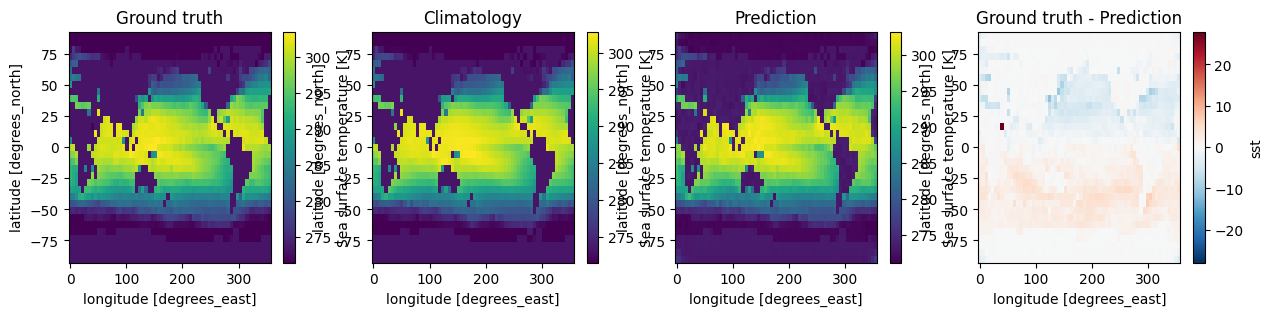

In [100]:
# Note first you need to modify your predictions so they are an xarray instead of a numpy array
# This way you can access the latitude, longitude and time for each point in the array

# We do this by taking a copy of the original z500 object which has the correct time,
# latitude and longitude, and replacing the data in this array with the predictions
pred_xarray = sst.sst.sel(time=test_years).isel(time=slice(lead_time_steps, None)).copy()
pred_xarray.data = pred_test

import matplotlib.pyplot as plt

t = xr.DataArray(np.datetime64('1995-11-01T09'))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))


sst.sst.sel(time=t).plot(ax=ax1)
ax1.set_title('Ground truth')

clim.sst.sel(dayofyear=t.dt.dayofyear).plot(ax=ax2)
ax2.set_title('Climatology')

pred_xarray.sel(time=t).plot(ax=ax3)
ax3.set_title('Prediction')

diff = sst.sst.isel(time=0)-pred_xarray.sel(time=t)
diff.plot(ax=ax4)
ax4.set_title('Ground truth - Prediction')

paper on el nino prediction using deep learning:
https://www.nature.com/articles/s41598-023-45739-3